In [ ]:
import numpy as np
from pymatching import Matching
import matplotlib.pyplot as plt
from scipy import sparse, linalg
import CompassCodes as cc
import stim 
import pandas as pd


In [ ]:
pip show stim

In [ ]:
!python --version

In [ ]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    # after_clifford_depolarization=0.001,
    # after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.05)
    # before_round_data_depolarization=0.001)

In [ ]:
print(repr(surface_code_circuit))

In [ ]:
sc_no_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [ ]:
sc_err =stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [ ]:
matching_from_c = Matching.from_stim_circuit(sc_err)
matching_from_c.draw()
print(matching_from_c)

In [ ]:
d = 5
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

In [ ]:
def convert_sparse_to_d(sparse_mat):
    rows, cols, values = sparse.find(sparse_mat)
    d = {}

    for i in range(len(rows)):
        plaq = rows[i]
        qubit = cols[i]

        if plaq not in d:
            d[plaq] = [cols[i]]
        else:
            d[plaq] += [cols[i]]
    sorted_d = dict(sorted(zip(d.keys(),d.values())))
    return sorted_d

d_z = convert_sparse_to_d(H_z)
print(d_z)

d_x = convert_sparse_to_d(H_x)
print(d_x)

In [ ]:
def qubit_to_plaq_d(H):
    """ Makes a dictionary that records which plaquettes belong to qubits
    """
    rows, cols, values = sparse.find(H)
    d = {}
    for i in range(len(cols)):
        q = cols[i]
        plaq = rows[i]

        if q not in d:
            d[q] = [plaq]
        else:
            d[q] += [plaq]
    return d
d = qubit_to_plaq_d(H_x)
print(d)

In [ ]:
def check_order_d(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    plaq_d = convert_sparse_to_d(H)
    order_d = {0:[], 1:[], 2:[], 3:[]}
    d = int(np.sqrt(H.shape[1]))

    for plaq in plaq_d:
        q_list = plaq_d[plaq] # the list of qubits in the plaquette
        if type == "X":
            if len(q_list) == 2 and max(q_list) <= H.shape[1]//2: # if the two qubit stabilizer is on the top bndry
                order_d[2] += [(q_list[1], plaq)]
                order_d[3] += [(q_list[0], plaq)]
            elif len(q_list) == 2 and max(q_list) >= H.shape[1]//2: # if the two qubit stabilizer is on bottom 
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
                order_d[2] += [(q_list[3], plaq)]
                order_d[3] += [(q_list[2], plaq)]
        if type == "Z": 
            if len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d == 0: # if the two qubit stabilizer is on the left bndry
                order_d[0] += [(q_list[0], plaq)]
                order_d[1] += [(q_list[1], plaq)]
            elif len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d != 0: # if the two qubit stabilizer is on right bndry 
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[1], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[3], plaq)]
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[2], plaq)]
                
    return order_d

order_d_x = check_order_d(H_x, "X")
print(order_d_x)
order_d_z = check_order_d(H_z, "Z")
print(order_d_z)


In [ ]:
def make_circuit_from_parity(H_x, H_z, p_err, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix
    """
    
    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    order_d_x = check_order_d(H_x, "X")
    order_d_z = check_order_d(H_z, "Z")
    
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z)
    num_qubits = len(qubit_d_x)
    d = int(np.sqrt(num_qubits))
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())]
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())]
    data_q_list = data_q_x_list

    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(len(plaq_d_x) + len(plaq_d_z))
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x)

    # reset the qubits
    for q in range(len(qubit_d_x)):
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go thru the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        q_z_list = order_d_z[order]
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
        
        circuit.append("TICK")
    
    circuit.append("H", plaq_d_x)
    circuit.append("X_ERROR", full_plaq_L, p_err)
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))
    
        circuit.append("Z_ERROR", data_q_list, p_err)
        circuit.append("MX", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_x: 
            
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_x_list] + [-num_ancillas + anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))
    
        circuit.append("X_ERROR", data_q_list, p_err)
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + q) for q in range(d)], 0)
    return circuit
            
circuit = make_circuit_from_parity(H_x, H_z, 0.05, "Z")            
print(repr(circuit))   

In [ ]:
d = 5
l = 2
num_shots = 10000

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

my_c = make_circuit_from_parity(H_x,H_z,0.05, "Z")
print(repr(my_c))

In [ ]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()

In [ ]:
matching_p.edges()

In [ ]:

matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()

In [ ]:
matching_my_c.edges()

In [ ]:
matching_sc = Matching.from_stim_circuit(sc_err)
matching_sc.draw()

In [ ]:
matching_sc.edges()

In [ ]:
dem = my_c.detector_error_model()
print(repr(dem))

In [ ]:
dem.diagram("matchgraph-svg")

In [ ]:
dem_stim = sc_err.detector_error_model()
print(repr(dem_stim))

In [ ]:
dem_stim.diagram("matchgraph-svg")

In [ ]:
def get_num_log_errors(circuit, matching, num_shots):
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    predictions = matching.decode_batch(detection_events)
    
    
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

# num_errors = get_num_log_errors(my_c, matching_my_c, num_shots)
# num_errors_stim = get_num_log_errors(sc_err, matching_from_c, num_shots)
# print("for my circuit", num_errors)
# print("for stim built in circuit", num_errors_stim)

In [ ]:
def get_log_error_p(p_list, H_x,H_z, type, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 2
type_d = {0:"X", 1:"Z"}
type=type_d[0]


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    
    d_dict[d] = get_log_error_p(p_list, H_x,H_z, num_shots)

In [ ]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l2_eta05_zmem.png", dpi=300)
plt.show()

In [ ]:
log_error_L = []
for p in p_list:
    sc_circuit = surface_code_circuit = stim.Circuit.generated("surface_code:rotated_memory_x",rounds=1, distance=3, before_measure_flip_probability=p)
    log_errors = get_num_log_errors(sc_circuit, matching_from_c, num_shots)
    log_error_L += [log_errors/num_shots]

plt.plot(p_list, log_error_L)
plt.show()


Now try to implement the elongated version

In [ ]:
d = 3
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

print("Hx",H_x)
# print("Hz",H_z)

In [ ]:
row_ind = 2
start = H_x.indptr[row_ind]
end = H_x.indptr[row_ind+1]

column_indices = H_x.indices[start:end]
print(sorted(column_indices))

In [ ]:
def check_order_d_elongated(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    # create the order dictionary to store the qubit ordering for each plaquette
    order_d = {}
    for row in range(H.shape[0]):
        order_d[row] = []

    # get the qubit ordering for each plaquette
    for row in range(H.shape[0]):
        start = H.indptr[row]
        end = H.indptr[row+1]
        qubits = sorted(H.indices[start:end]) # the qubits in the plaquette
        
        if type == "Z":
            for i in range(len(qubits)//2):
                match_qubit_ind = np.where(qubits == (qubits[i] + d))[0][0]
                order_d[row] += [(qubits[i], row)]
                order_d[row] += [(qubits[match_qubit_ind], row)]

        if type == "X":
            for qubit in qubits:
                order_d[row] += [(qubit, row)]
    return order_d

In [ ]:

order_d_x = check_order_d_elongated(H_x, "X")
print(order_d_x)
print(H_x.shape)

In [ ]:
def make_elongated_circuit_from_parity(H_x, H_z, d, p_err, eta, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix

    I think the error type I wanna use is pauli_channel_1(px, py, pz)
    """
    px = 0.5*p_err/(1+eta)
    pz = p_err*(eta/(1+eta))

    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    # get the qubit ordered properly for each plaquette
    order_d_x = check_order_d_elongated(H_x, "X")
    order_d_z = check_order_d_elongated(H_z, "Z")
    
    # get the plaquettes that belong to each qubit
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z) # total number of plaquettes to initialize
    num_qubits_x = len(qubit_d_x)
    num_qubits_z = len(qubit_d_z)
    
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())] # all the x data qubits
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())] # all the z data qubits
    data_q_list = data_q_x_list # change this later when wanna do X and Z seperately


    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(num_ancillas)
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x) # only the X plaqs need H

    # reset the qubits
    for q in range(len(qubit_d_x)): # go through all the qubits, might need to change when qubit_d_x doesn't have all the qubits
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go through the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        circuit.append("TICK")


    for order in order_d_z: # go through the qubits in order of gates
        q_z_list = order_d_z[order]

        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
    
    circuit.append("H", plaq_d_x)
    # circuit.append("PAULI_CHANNEL_1", full_plaq_L, [px,px,pz]) # measurement errors???
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))

        circuit.append("PAULI_CHANNEL_1", data_q_x_list, [px,px,pz])
        # circuit.append("Z_ERROR", data_q_x_list, p_err) # errors on the data qubits
        circuit.append("MX", data_q_x_list)

        # reconstruct each plaquette
        for i in plaq_d_x: 
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_x + q for q in q_x_list] + [-num_ancillas + anc - num_qubits_x]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits_x + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))

        circuit.append("PAULI_CHANNEL_1", data_q_z_list, [px,px,pz])
        # circuit.append("X_ERROR", data_q_list, p_err) # errors on the data qubits
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_z + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits_z]
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-num_qubits_z + q) for q in range(d)], 0)
    return circuit

In [ ]:
def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [ ]:
d = 5
l = 3

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']
my_c = make_elongated_circuit_from_parity(H_x,H_z, d, 0.05, 0.5, "Z")
print(H_x)
print(repr(my_c))

In [ ]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()


In [ ]:
matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()
# my_c.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D13', ])

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}

def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_check_matrix(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

In [ ]:
for d in d_dict:
    plt.plot(p_list*prob_scale[type], d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
# plt.savefig("l3_eta1.67_zmem.png", dpi=300)
plt.show()

In [ ]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l3_eta05_xmem.png", dpi=300)
plt.show()

Trying to make circuit for clifford deformed codes

In [ ]:
from CompassCodes import CD_data_func, Clifford_vectorTrans
import CompassCodes as cc

In [ ]:
code = cc.CompassCode(d=3, l=2)

CD_data = cc.CD_data_func(code.qbit_dict.values(), special='XZZXonSqu', ell=2, size=3)

print(CD_data)

In [ ]:
circuit = stim.Circuit("""
QUBIT_COORDS(1, 1) 1
QUBIT_COORDS(2, 0) 2
QUBIT_COORDS(3, 1) 3
QUBIT_COORDS(5, 1) 5
QUBIT_COORDS(1, 3) 8
QUBIT_COORDS(2, 2) 9
QUBIT_COORDS(3, 3) 10
QUBIT_COORDS(4, 2) 11
QUBIT_COORDS(5, 3) 12
QUBIT_COORDS(6, 2) 13
QUBIT_COORDS(0, 4) 14
QUBIT_COORDS(1, 5) 15
QUBIT_COORDS(2, 4) 16
QUBIT_COORDS(3, 5) 17
QUBIT_COORDS(4, 4) 18
QUBIT_COORDS(5, 5) 19
QUBIT_COORDS(4, 6) 25
RX 1 3 5 8 10 12 15 17 19
R 2 9 11 13 14 16 18 25
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
CX 2 3 16 17 11 12 15 14 10 9 19 18
DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
TICK
CX 2 1 16 15 11 10 8 14 3 9 12 18
DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
TICK
CX 16 10 11 5 25 19 8 9 17 18 12 13
DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
TICK
CX 16 8 11 3 25 17 1 9 10 18 5 13
DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
TICK
H 2 11 16 25
DEPOLARIZE1(0.001) 2 11 16 25
TICK
MR 2 9 11 13 14 16 18 25
DETECTOR(2, 0, 0) rec[-8]
DETECTOR(2, 4, 0) rec[-3]
DETECTOR(4, 2, 0) rec[-6]
DETECTOR(4, 6, 0) rec[-1]
REPEAT 2 {
    TICK
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    DEPOLARIZE2(0.001) 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    DEPOLARIZE2(0.001) 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    DEPOLARIZE2(0.001) 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    DEPOLARIZE2(0.001) 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    DEPOLARIZE1(0.001) 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    SHIFT_COORDS(0, 0, 1)
    DETECTOR(2, 0, 0) rec[-8] rec[-16]
    DETECTOR(2, 2, 0) rec[-7] rec[-15]
    DETECTOR(4, 2, 0) rec[-6] rec[-14]
    DETECTOR(6, 2, 0) rec[-5] rec[-13]
    DETECTOR(0, 4, 0) rec[-4] rec[-12]
    DETECTOR(2, 4, 0) rec[-3] rec[-11]
    DETECTOR(4, 4, 0) rec[-2] rec[-10]
    DETECTOR(4, 6, 0) rec[-1] rec[-9]
}
MX 1 3 5 8 10 12 15 17 19
DETECTOR(2, 0, 1) rec[-8] rec[-9] rec[-17]
DETECTOR(2, 4, 1) rec[-2] rec[-3] rec[-5] rec[-6] rec[-12]
DETECTOR(4, 2, 1) rec[-4] rec[-5] rec[-7] rec[-8] rec[-15]
DETECTOR(4, 6, 1) rec[-1] rec[-2] rec[-10]
OBSERVABLE_INCLUDE(0) rec[-3] rec[-6] rec[-9]
""")

In [ ]:
d = 3
circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_x",
                    rounds=3,
                    distance=3,
                    after_clifford_depolarization=0,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=0.1,
                    before_round_data_depolarization=0,
                )
circuit.diagram("timeline-svg")

In [ ]:
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
circuit_obj = CDCompassCodeCircuit(d=3, l=2, p_params=[0,0,0.1], eta=0.5, type='Z')
circuit = circuit_obj.make_elongated_circuit_from_parity()
# circuit.diagram('timeslice-svg', tick=range(6,12))
circuit.diagram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching

p_list = np.linspace(0.001, 0.011, 10)
d_list = [5,7,9]
num_shots = 1000000

log_error_L = []

for d in d_list:
    errors = []
    for p in p_list:
        
        circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_z",
                    rounds=d,
                    distance=d,
                    after_clifford_depolarization=p,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=p,
                    before_round_data_depolarization=p,
                )
        dem = circuit.detector_error_model() # what does the decompose do?
        matchgraph = Matching.from_detector_error_model(dem)
        sampler = circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)
        predictions = matchgraph.decode_batch(syndrome)
        num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        errors.append(num_errors/num_shots)

    log_error_L.append(np.array(errors))

# circuit.diagram("timeline-svg")

In [ ]:
circuit = stim.Circuit.generated(
                    "surface_code:rotated_memory_x",
                    rounds=3,
                    distance=3,
                    after_clifford_depolarization=0.1,
                    after_reset_flip_probability=0,
                    before_measure_flip_probability=0.1,
                    before_round_data_depolarization=0.1,
                )
circuit.diagram("timeline-svg")
# print(repr(circuit))

In [ ]:
%matplotlib inline

plt.figure()
for d, logical_errors in zip(d_list, log_error_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(p_list, logical_errors, yerr=std_err, label="d={}".format(d))
# plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

In [2]:
# debug the CD_Circuit param
circuit_obj = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='X')
circuit = circuit_obj.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1,
                                            between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC")
circuit.diagram('timeline-svg')
dem = circuit.detector_error_model(decompose_errors=False)
dem

stim.DetectorErrorModel('''
    error(0.0666667) D0 D2
    error(0.0666667) D0 D3
    error(0.124444) D0 L0
    error(0.0666667) D1 D3
    error(0.0666667) D1 L0
    error(0.0666667) D2
    error(0.124444) D3
    error(0.0345253) D4 D6
    error(0.0345253) D4 D6 D9
    error(0.0345253) D4 D7
    error(0.0345253) D4 D7 D9 D10
    error(0.0345253) D4 D8 D10 L0
    error(0.0345253) D4 D8 L0
    error(0.0666667) D4 L0
    error(0.0345253) D5 D7
    error(0.0345253) D5 D7 D10
    error(0.0345253) D5 D10 L0
    error(0.0345253) D5 L0
    error(0.0345253) D6
    error(0.0345253) D6 D9
    error(0.0666667) D7
    error(0.0345253) D7 D9 D11
    error(0.0345253) D7 D11
    error(0.0345253) D8
    error(0.0345253) D8 D10
    error(0.0666667) D9
    error(0.0345253) D9 D10
    error(0.0345253) D9 D11
    error(0.0666667) D10
    error(0.0345253) D11
    error(0.0345253) D12 D14
    error(0.0345253) D12 D14 D17
    error(0.0345253) D12 D15
    error(0.0345253) D12 D15 D17 D18
    error(0.0345253) D

In [3]:
# test joint_prob calculator directly from the parent function
from compass_code_correlated_error import CorrelatedDecoder
corr_decoder = CorrelatedDecoder(d=3, l=2, eta=0.5, corr_type=None)
joint_prob = corr_decoder.get_joint_prob(dem)
cond_prob_dict = corr_decoder.get_conditional_prob(joint_prob)
matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)

shots = 1
# dem = stim.DetectorErrorModel("error(0.1) D0 D1\n error(0.2) D2 D1 D4 L0 \n error(0.3) D1 L0")
# for inst in dem:
#     decomp_inst = corr_decoder.decompose_dem_instruction_pairwise(inst)
#     print(decomp_inst)

# joint_prob = corr_decoder.get_joint_prob(dem)
# edges_in_correction = [[-1,1]
sampler = circuit.compile_detector_sampler(seed=42)
syndrome, observable_flips = sampler.sample(shots, separate_observables=True)
corrections = np.zeros((shots, 2)) # largest fault id is 1, len of correction = 2
for i in range(shots):
    edges_in_correction = matchgraph.decode_to_edges_array(syndrome[i])
    # update weights based on conditional probabilities
    updated_dem = corr_decoder.edit_dem(edges_in_correction, dem, cond_prob_dict)
    print("Updated DEM:", updated_dem)



# matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
# matchgraph.draw()
# sampler = circuit.compile_detector_sampler(seed=42)
# syndrome, observable_flips = sampler.sample(shots, separate_observables=True)

# corrections = matchgraph.decode_batch(syndrome, enable_correlations=False)
# print(corrections)

# print(joint_prob)
# print(cond_prob)

# new_dem = corr_decoder.edit_dem(edges_in_correcti÷on, dem, cond_prob)
# print(joint_prob)
# print(cond_prob)
# print(updated_dem)

# stim.DetectorErrorModel('''
#     error(0.0666667) D0 D2
#     error(0.0666667) D0 D3
#     error(0.124444) D0 L0
#     error(0.0666667) D1 D3
#     error(0.0666667) D1 L0
#     error(0.0666667) D2
#     error(0.124444) D3
#     error(0.0345253) D4 D6
#     error(0.0345253) D4 D6 D9
#     error(0.0345253) D4 D7
#     error(0.0345253) D4 D7 D9 D10
#     error(0.0345253) D4 D8 D10 L0 - not getting the L0 on the hyperedges
#     error(0.0345253) D4 D8 L0
#     error(0.0666667) D4 L0
#     error(0.0345253) D5 D7
#     error(0.0345253) D5 D7 D10
#     error(0.0345253) D5 D10 L0
#     error(0.0345253) D5 L0
#     error(0.0345253) D6
#     error(0.0345253) D6 D9
#     error(0.0666667) D7
#     error(0.0345253) D7 D9 D11
#     error(0.0345253) D7 D11
#     error(0.0345253) D8
#     error(0.0345253) D8 D10
#     error(0.0666667) D9
#     error(0.0345253) D9 D10
#     error(0.0345253) D9 D11
#     error(0.0666667) D10
#     error(0.0345253) D11
#     error(0.0345253) D12 D14
#     error(0.0345253) D12 D14 D17
#     error(0.0345253) D12 D15
#     error(0.0345253) D12 D15 D17 D18
#     error(0.0345253) D12 D16 D18 L0
#     error(0.0345253) D12 D16 L0
#     error(0.0666667) D12 L0
#     error(0.0345253) D13 D15
#     error(0.0345253) D13 D15 D18
#     error(0.0345253) D13 D18 L0
#     error(0.0345253) D13 L0
#     error(0.0345253) D14
#     error(0.0345253) D14 D17
#     error(0.0666667) D15
#     error(0.0345253) D15 D17 D19
#     error(0.0345253) D15 D19
#     error(0.0345253) D16
#     error(0.0345253) D16 D18
#     error(0.0666667) D17
#     error(0.0345253) D17 D18
#     error(0.0345253) D17 D19
#     error(0.0666667) D18
#     error(0.0345253) D19
#     detector D20
#     detector D21
#     detector D22
#     detector D23
# ''')



[stim.DemTarget('D4'), stim.DemTarget('D8'), stim.DemTarget('L0')]
[stim.DemTarget('D8'), stim.DemTarget('D10'), stim.DemTarget('L0')]
[stim.DemTarget('D12'), stim.DemTarget('D16'), stim.DemTarget('L0')]
[stim.DemTarget('D16'), stim.DemTarget('D18'), stim.DemTarget('L0')]
Updated DEM: error(0.06666666666666666574) D0 D2
error(0.06666666666666666574) D0 D3
error(0.1244444444444444409) D0 L0
error(0.06666666666666666574) D1 D3
error(0.06666666666666666574) D1 L0
error(0.06666666666666666574) D2
error(0.1244444444444444409) D3
error(0.0345253318743686255) D4 D6
error(0.0345253318743686255) D4 D6
error(0.0345253318743686255) D6 D9
error(0.0345253318743686255) D4 D7
error(0.0345253318743686255) D4 D7
error(0.0345253318743686255) D7 D9
error(0.0345253318743686255) D9 D10
error(0.0345253318743686255) D4 D8 L0
error(0.0345253318743686255) D8 D10 L0
error(0.0345253318743686255) D4 D8 L0
error(0.06666666666666666574) D4 L0
error(0.0345253318743686255) D5 D7
error(0.0345253318743686255) D5 D7
err

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

%load_ext line_profiler

In [1]:
import stim

# Correct constructors
t_D1 = stim.target_relative_detector_id(1)            # D1
t_D2 = stim.target_relative_detector_id(2)            # D2
t_L0 = stim.target_logical_observable_id(0)  # L0

# assemble into a list
# targets = [t_D1, t_D2, t_L0]
targets = [t_L0]

# make a new DetectorErrorModel
dem = stim.DetectorErrorModel()
# dem.append("error", 0.3, targets)
decomposed_inst = {}
decomposed_inst["observables"] = targets
targets.append([stim.target_logical_observable_id(l.val) for l in decomposed_inst["observables"]]) 
dem.append("error", [0.3], targets)

print(dem)

ValueError: Bad target '[stim.DemTarget('L0')]' for instruction 'error'.

In [ ]:
import stim


AttributeError: module 'stim' has no attribute 'target_detector_id'

In [ ]:


p_list = np.linspace(0.05, 0.13, 10)
d_list = [7,9,11]
# d = 3
# l_list = [2,3,4]
l = 2
num_shots = 1000

log_error_L = []

for d in d_list:
    errors = []
    for p in p_list:
        circuit_obj = CDCompassCodeCircuit(d=d, l=l, eta=0.5, type='Z')
        # circuit = circuit_obj.make_elongated_circuit_from_parity(before_measure_flip=0.001, after_clifford_depolarization=0.003, before_round_data_pauli_channel=0, between_round_idling_pauli_channel=p, idling_dephasing=0, CD_circuit=True)
        circuit = circuit_obj.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=p, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="XZZXonSqu")
        dem = circuit.detector_error_model(approximate_disjoint_errors=True)
        matchgraph = Matching.from_detector_error_model(dem)
        sampler = circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)
        predictions = matchgraph.decode_batch(syndrome)
        num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        errors.append(num_errors/num_shots)
    log_error_L.append(np.array(errors))
    

In [ ]:
import cProfile
import pstats


circuit_obj = CDCompassCodeCircuit(d=19, l=6, eta=0.5, type='X')
CD_type="ZXXZonSqu"

# profiler = cProfile.Profile()
# profiler.enable()

circuit = circuit_obj.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type=CD_type)
dem = circuit.detector_error_model(approximate_disjoint_errors=True)
# circuit.diagram('timeline-svg')
# profiler.disable()

# Process and print statistics
# stats = pstats.Stats(profiler)
# stats.sort_stats("cumulative").print_stats()

In [ ]:
import cProfile
import pstats
import CompassCodes as cc


circuit_obj = CDCompassCodeCircuit(d=19, l=6, eta=0.5, type='Z')
curr_circuit = stim.Circuit()

def add_meas_test(circuit_obj, curr_circuit):
    """ Add a measurement round to the current circuit
        This is for the CD compass code circuit only
    """
    CD_type = "XZZXonSqu" # options are "SC", "XZZXonSqu", "XZZXonAll", "XYonSqu", "XYonAll", "I"
    p_i, p_gate, p_i_round = 0, 0, 0.1

    # get the qubit ordering
    stab_d_x,stab_d_z = circuit_obj.convert_sparse_to_d()

    # get the qubit ordered properly for each stabilizer
    order_d_x, order_d_z = circuit_obj.check_order_d_elongated()

    # get the stabilizer that belong to each qubit
    qubit_d_x,qubit_d_z = circuit_obj.qubit_to_stab_d()

    # get the data for the clifford deformation for the basis setup
    if CD_type != "SC":
        CD_data = cc.CD_data_func(circuit_obj.code.qbit_dict.values(), special=CD_type, ell=circuit_obj.l, size=circuit_obj.d) # data for which qubits have a transformation applied, dictionary 
    else:
        CD_data = cc.CD_data_func(circuit_obj.code.qbit_dict.values(), special="I", ell=circuit_obj.l, size=circuit_obj.d)
        

    # general parameters
    num_ancillas = len(stab_d_x) + len(stab_d_z) # total number of stabilizer to initialize
    num_qubits_x = len(qubit_d_x)
    num_qubits_z = len(qubit_d_z)

    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())] # all the x data qubits
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())] # all the z data qubits
    data_q_list = [num_ancillas + q for q in range(circuit_obj.d**2)] # change this later when wanna do X and Z seperately


    # convention - X stabs first, then Z stabs starting with 0
    full_stab_L = range(num_ancillas)

    # profiler = cProfile.Profile()

    circuit = curr_circuit

    px = 0.5*p_i_round/(1+circuit_obj.eta)
    pz = p_i_round*(circuit_obj.eta/(1+circuit_obj.eta))

    circuit.append("PAULI_CHANNEL_1",range(num_ancillas + num_qubits_x), [px,px,pz]) # idling error on all qubits in between measurement rounds
    circuit.append("H", range(num_ancillas))


    circuit.append("Z_ERROR", [num_ancillas + q for q in list(qubit_d_x.keys())], p_i) # idling error on the data qubits during round
    # profiler.enable()

    # go through each stabilizer in order, X stabilizers first
    for order in order_d_x:
        q_x_list = order_d_x[order] # (qubit, ancilla) in each stabilizer, not offset for x ancillas for the z ancillas, or ancillas for the data qubits

        if p_i > 0:
            active_qubits = {q for q,_ in q_x_list} # the dummy list for qubits that are idling
            active_ancilla = order
            
            # keep track of the idling qubits outside the stabilizer
            inactive_ancillas = [anc for anc in range(num_ancillas) if anc != active_ancilla]
            inactive_qubits = [q + num_ancillas for q in range(num_qubits_z) if q not in active_qubits]
            full_inactive_list = inactive_ancillas + inactive_qubits
        
        # apply a CX to each qubit in the stabilizer in the correct order
        for q,anc in q_x_list:
            ctrl = anc
            target = q + num_ancillas

            gate = "CX" if CD_type == "SC" else ("CZ" if CD_data[q] == 2 else "CX")

            circuit.append(gate, [ctrl, target]) # apply the gate gate

            # apply the depolarizing channel to the CX gate
            circuit.append("DEPOLARIZE2", [ctrl, target], p_gate)

            if p_i > 0:
                # apply idling errors to the qubits in the stabilizer without CX
                for other_q in active_qubits - {q}:
                    circuit.append("Z_ERROR", [other_q + num_ancillas], p_i) # Idling error on the X qubits
                circuit.append("Z_ERROR", full_inactive_list, p_i) # Idling error on the ancillas and qubits outside the stabilizer


    circuit.append("Z_ERROR", [num_ancillas + q for q in data_q_x_list], p_i)# idling error on the data qubits during round
    circuit.append("TICK")

    # profiler.enable()
    # now do the Z stabilizers
    for order in order_d_z: 
        
        q_z_list = order_d_z[order] # (qubit, ancilla) in each stabilizer, not offset for x ancillas for the z ancillas, or ancillas for the data qubits

        if p_i > 0:
            active_qubits = {q for q,_ in q_z_list} # the dummy list for qubits that are idling
            active_ancilla = order + len(stab_d_x) # the ancilla for this stabilizer, shifted to account for X stabs

            # keep track of the idling qubits outside the stabilizer
            inactive_ancillas = [anc for anc in range(num_ancillas) if anc != active_ancilla]
            inactive_qubits = [q + num_ancillas for q in range(num_qubits_z) if q not in active_qubits]
            full_inactive_list = inactive_ancillas + inactive_qubits
        
        # apply a CX to each qubit in the stabilizer in the correct order
        for q,anc in q_z_list:
            ctrl = anc + len(stab_d_x) # ancillas are shifted to account for X stabs
            target = q + num_ancillas

            gate = "CZ" if CD_type == "SC" else ("CX" if CD_data[q] == 2 else "CZ")

            circuit.append(gate, [ctrl, target]) # apply the CX gate
            circuit.append("DEPOLARIZE2", [ctrl, target], p_gate) # CNOT gate errors

            if p_i > 0:
                # apply idling errors to the qubits in the stabilizer without CX
                for other_q in active_qubits - {q}:
                    circuit.append("Z_ERROR", [other_q + num_ancillas], p_i) # Idling error on the X qubits
                circuit.append("Z_ERROR", full_inactive_list, p_i) # Idling error on the ancillas and qubits outside the stabilizer

    # profiler.disable()

    circuit.append("H", range(num_ancillas))
    circuit.append("TICK")
    return circuit



# Process and print statistics
# stats = pstats.Stats(profiler)
# stats.sort_stats("cumulative").print_stats()
# circuit.diagram('timeline-svg')

In [ ]:
%lprun -f add_meas_test add_meas_test(circuit_obj, curr_circuit)

In [ ]:
import itertools
l_eta_cd_type_arr = list(itertools.product([2,3,4,5,6],[0.5,5,10,50,100],["SC", "XZZXonSqu", "ZXXZonSqu"]))
reps = 1000//len(l_eta_cd_type_arr)
print(len(l_eta_cd_type_arr), reps)
print(1e6/reps)

Get start drafting for the pymatching correlated decoder

In [ ]:
def get_num_log_errors_DEM_correlations_pymatching(circuit, num_shots):
        """
        Get the number of logical errors from the detector error model
        :param circuit: stim.Circuit object
        :param num_shots: number of shots to sample
        :return: number of logical errors
        """
        dem = circuit.detector_error_model(decompose_errors=True) # what does the decompose do?
        matchgraph_corr = Matching.from_detector_error_model(dem,enable_correlations=True)
        matchgraph = Matching.from_detector_error_model(dem,enable_correlations=False)
        sampler = circuit.compile_detector_sampler(seed=42)
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)
        predictions = matchgraph.decode_batch(syndrome, enable_correlations=False)
        predictions_corr = matchgraph_corr.decode_batch(syndrome, enable_correlations=True)
        log_errors_array = np.any(np.array(observable_flips) != np.array(predictions), axis=1)
        log_errors_array_corr = np.any(np.array(observable_flips) != np.array(predictions_corr), axis=1)
        return log_errors_array, log_errors_array_corr

In [ ]:

num_shots = 10000
d_dict = {9:[],11:[], 13:[], 15:[]}
p_list = np.linspace(0.07, 0.15, 10)


for d in d_dict:
    log_errors_list_tot = []
    log_errors_list_corr = []
    for p in p_list:
        circuit_obj_z = CDCompassCodeCircuit(d=d, l=3, eta=0.5, type='Z')
        circuit_obj_x = CDCompassCodeCircuit(d=d, l=3, eta=0.5, type='X')
        circuit_x = circuit_obj_x.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=p, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="XZZXonSqu")
        circuit_z = circuit_obj_z.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=p, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="XZZXonSqu")
        log_errors_array_x, log_errors_array_x_corr = get_num_log_errors_DEM_correlations_pymatching(circuit_x, num_shots)
        log_errors_array_z, log_errors_array_z_corr = get_num_log_errors_DEM_correlations_pymatching(circuit_z, num_shots)
        log_errors_x = np.sum(log_errors_array_x)
        log_errors_z = np.sum(log_errors_array_z)
        log_errors_tot = np.sum(np.logical_xor(log_errors_array_x, log_errors_array_z)) # I guess double counting Y errors means that correlations mean nothing?

        log_errors_tot_corr = np.sum(np.logical_xor(log_errors_array_x_corr, log_errors_array_z_corr))
        log_errors_list_tot.append(log_errors_tot)
        log_errors_list_corr.append(np.sum(log_errors_tot_corr))
    d_dict[d] = (np.array(log_errors_list_tot)/num_shots, np.array(log_errors_list_corr)/num_shots)




In [ ]:
from compass_code_correlated_error import CorrelatedDecoder
num_shots = 10000
d_dict = {9:[],11:[], 13:[], 15:[]}
p_list = np.linspace(0.05, 0.14, 10)
l = 2
eta = 0.5
corr_type = "CORR_XZ"
cd_type = "SC"

for d in d_dict:
    corr_decoder = CorrelatedDecoder(eta, d, l, corr_type)
    log_err_x_arr = corr_decoder.get_log_error_circuit_level(p_list, 'X', num_shots, cd_type=cd_type)
    log_err_z_arr = corr_decoder.get_log_error_circuit_level(p_list, 'Z', num_shots, cd_type=cd_type)

    log_errors_z = np.sum(log_err_x_arr, axis=1) 
    log_errors_x = np.sum(log_err_z_arr, axis=1)        
    log_errors_total = np.sum(np.logical_xor(log_err_x_arr, log_err_z_arr), axis=1)
    d_dict[d] = log_errors_total/num_shots


In [ ]:
scaled_p = 4/3*np.array(p_list)

fig, ax = plt.subplots()

for d in d_dict:
    ax.plot(scaled_p, d_dict[d][0], label="d={} uncorrelated".format(d))
    ax.plot(scaled_p, d_dict[d][1], '--', label="d={} correlated".format(d))
plt.show()


In [ ]:
import compass_code_correlated_error as corr_d
data = corr_d.get_data(1, [3,5,7],2,[0.1,0.5],0.5,"CORR_XZ",True,"code_cap","SC")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

p = 0.1
circuit_obj = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='X')
circuit = circuit_obj.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0, between_round_idling_pauli_channel=p, idling_dephasing=0, CD_type=None)
dem = circuit.detector_error_model()
print(repr(dem))
circuit.diagram('timeline-svg')

In [ ]:
%matplotlib inline

plt.figure()
for d, logical_errors in zip(d_list, log_error_L):
    std_err = (logical_errors*(1-logical_errors)/num_shots)**0.5
    plt.errorbar(p_list, logical_errors, yerr=std_err, label=f"d={d}, l={l}")
# plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

In [ ]:
# test a specific error type to make sure the detector flips

Now try to do multiple observables

In [ ]:
test_circuit = stim.Circuit("""
QUBIT_COORDS(0, 0) 0
QUBIT_COORDS(1, 0) 1
QUBIT_COORDS(0, 1) 2
QUBIT_COORDS(1, 1) 3
OBSERVABLE_INCLUDE(0) X0 X1
OBSERVABLE_INCLUDE(1) Z0 Z2
MPP X0*X1*X2*X3 Z0*Z1 Z2*Z3
X_ERROR(0.001) 0 1 2 3
MPP X0*X1*X2*X3 Z0*Z1 Z2*Z3
DETECTOR rec[-1] rec[-4]
DETECTOR rec[-2] rec[-5]
DETECTOR rec[-3] rec[-6]
OBSERVABLE_INCLUDE(0) X0 X1
OBSERVABLE_INCLUDE(1) Z0 Z2
""")
test_circuit.diagram('timeline-svg')
dem = test_circuit.detector_error_model()
dem
matchgraph = Matching.from_detector_error_model(dem)
print(dem)

In [ ]:
# dem = test_circuit.detector_error_model(flatten_loops=True)
# print(repr(dem))
# detectors_d = {"X": ["D2"], "Z": ["D0", "D1"]}

def isolate_observable(dem: stim.DetectorErrorModel, detectors_d) -> stim.DetectorErrorModel:
    """Returns a new DEM containing only the detector faults for a specific logical observable."""
    dem_x = stim.DetectorErrorModel()
    dem_z = stim.DetectorErrorModel()
    dets_x = {}
    dets_z = {}
    detector_coords = []

    # Deconstruct the DEM and split into X and Z detector dictionaries. Each instruction is stored in the dictionary with probability as the value.
    # Hyperedges are not allowed
    for inst in dem:
        if inst.type == "error":
            # for each inst check whether its a detector or a logic is_relative_detector_id 
            prob_err = inst.args_copy()[0]
            targets = inst.targets_copy()
            dets_x_list = []
            dets_z_list = []
            for target in targets:
                if target.is_relative_detector_id():
                    det = "D" + str(target.val)
                    if det in detectors_d["X"]:
                        dets_x_list.append(det)
                    elif det in detectors_d["Z"]:
                        dets_z_list.append(det)
                elif target.is_logical_observable_id():
                    observable_id = "L" + str(target.val)
                    if observable_id == "L0":
                        dets_x_list.append(observable_id)
                    elif observable_id == "L1":
                        dets_z_list.append(observable_id)
            if dets_x_list:

                key = tuple(dets_x_list)
                print("X key", key)
                if key not in dets_x:
                    dets_x[key] = prob_err
                else:
                    print("hyperege detected in X DEM, combining probabilities")
                    curr_p = dets_x[key]
                    dets_x[key] = curr_p + prob_err - 2 * curr_p * prob_err  # combine probabilities if multiple error mechanisms detected
            if dets_z_list:
                key = tuple(dets_z_list)
                print("Z key",key)
                if key not in dets_z:
                    dets_z[key] = prob_err
                else:
                    print("hyperege detected in Z DEM, combining probabilities")
                    curr_p = dets_z[key]
                    dets_z[key] = curr_p + prob_err - 2 * curr_p * prob_err
        else:
            detector_coords.append(inst) # not sure if I need this to be seperate for X and Z qubits, but I will just keep it and add it to both DEMs
    
    # Construct the new DEMs for X and Z observables
    for key in dets_x.keys():
        prob = dets_x[key]
        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0] == "D" else stim.target_logical_observable_id(0) for det in key]
        dem_x.append("error", prob, targets=targets)
    for key in dets_z.keys():
        prob = dets_z[key]
        targets = [stim.target_relative_detector_id(int(det[1:])) if det[0] == "D" else stim.target_logical_observable_id(1) for det in key]
        dem_z.append("error", prob, targets=targets)

    return dem_x, dem_z

# dem_x,dem_z = isolate_observable(dem)
# print(repr(dem_x))
# print(repr(dem_z))
# dem_z
# print(repr(dem))

# matchgraph = Matching.from_stim_circuit(test_circuit)
# print(matchgraph.edges())
# matchgraph.draw()
# matchgraph.edges()


In [ ]:
p_list = np.linspace(0.01, 0.1, 10)
num_shots = 10
errors = []
for p in p_list:
    circuit = test_circuit
    dem = circuit.detector_error_model(decompose_errors=True) 

#     matchgraph_x = Matching.from_detector_error_model(dem, logical_observable_index=0)
#     matchgraph_z = Matching.from_detector_error_model(dem, logical_observable_index=1)

#     sampler = circuit.compile_detector_sampler()
#     syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True)

#     predictions = matchgraph.decode_batch(syndrome)
#     num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
#     errors.append(num_errors/num_shots)

# %matplotlib inline

# plt.figure()
# # std_err = (errors*(1-errors)/num_shots)**0.5
# plt.errorbar(p_list, errors, label="d={}".format(2))
# plt.yscale("log")
# plt.xlabel("Physical error rate")
# plt.ylabel("Logical error rate")
# plt.legend(loc=0);

In [ ]:
def get_syndrome_sep(detectors_d, syndrome):
    # Parse detector indices
    x_ind = [int(s[1:]) for s in detectors_d["X"]]
    z_ind = [int(s[1:]) for s in detectors_d["Z"]]

    # Total number of detectors
    total_len = syndrome.shape[1]

    # Create boolean masks
    x_mask = np.zeros(total_len, dtype=bool)
    z_mask = np.zeros(total_len, dtype=bool)
    x_mask[x_ind] = True
    z_mask[z_ind] = True

    # Expand to 2D masks
    x_mask_2d = np.tile(x_mask, (syndrome.shape[0], 1))
    z_mask_2d = np.tile(z_mask, (syndrome.shape[0], 1))

    # Apply masks: keep values where True, else set to False
    syndrome_x_dets = np.where(x_mask_2d, syndrome, False)
    syndrome_z_dets = np.where(z_mask_2d, syndrome, False)

    return syndrome_x_dets, syndrome_z_dets

# test with 2 qubit code eg 
# detectors_d = {"X": ["D2"], "Z": ["D0", "D1"]}
# syndrome = np.array([[False, True, True], [False, True, True]]) 
# syndrome_x, syndrome_z = get_syndrome_sep(detectors_d, syndrome)
# print(syndrome_x, syndrome_z)


In [ ]:
# get the logicals for the test circuit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stim
from pymatching import Matching
from clifford_deformed_cc_circuit import CDCompassCodeCircuit

p_list = np.linspace(0.005, 0.15, 10)
d_list = [3,5,7,9]
# d_list = [3]
num_shots = 1000

log_error_L_x = []
log_error_L_z = []

for d in d_list:
    errors_x = []
    errors_z = []
    print(f"d = {d}")
    for p in p_list:
        circuit_obj = CDCompassCodeCircuit(d=d, l=2, p_params=[0,0,p], eta=0.5, type='X')
        mpp_circuit, detectors_d = circuit_obj.make_elongated_MPP_circuit_from_parity()
        print(len(mpp_circuit.shortest_graphlike_error()), "shortest graph error") # finds the shortest graphlike error for the og circuit ... wanna check the individual circuits
        dem = mpp_circuit.detector_error_model()
        # dem_x, dem_z = circuit_obj.isolate_observables_DEM()
        # print(repr(dem))
        # print(len(dem_z.shortest_graphlike_error()))
        # matchgraph_x = Matching.from_detector_error_model(dem_x)
        # matchgraph_z = Matching.from_detector_error_model(dem_z)
        matchgraph = Matching.from_detector_error_model(dem)
        # print(matchgraph_z.edges())
        sampler = mpp_circuit.compile_detector_sampler()
        syndrome, observable_flips = sampler.sample(num_shots, separate_observables=True) # observable flips is the same shape as syndrome i think 
        # print(observable_flips.shape)
        # syndrome_x, syndrome_z = get_syndrome_sep(detectors_d, syndrome) 

        # now filter the syndrome based on the correct detectors
        # print(syndrome.shape)
        # print(observable_flips.shape)
        predictions = matchgraph.decode_batch(syndrome)
        # print(predictions.shape)
        # print(syndrome_x)
        # predictions_x = matchgraph_x.decode_batch(syndrome_x)
        # predictions_z = matchgraph_z.decode_batch(syndrome_z)

        # num_errors = np.sum(np.any(np.array(observable_flips) != np.array(predictions), axis=1))
        # errors_x.append(num_errors/num_shots)
        # num_errors_x = np.sum(np.any(np.array(observable_flips) != np.array(predictions_x), axis=1))
        # num_errors_z = np.sum(np.any(np.array(observable_flips) != np.array(predictions_z), axis=1))
        num_errors_x = np.sum(np.array(observable_flips)[:, 1] != np.array(predictions)[:,1])
        # num_errors_x = np.sum(np.array(observable_flips)[:, 0] != np.array(predictions_x)[:,0])
    #     num_errors_z =  np.sum(np.array(observable_flips)[:, 1] != np.array(predictions_z)[:,0])
        errors_x.append(num_errors_x/num_shots)
    #     errors_z.append(num_errors_z/num_shots)
    log_error_L_x.append(np.array(errors_x))
    # log_error_L_z.append(np.array(errors_z))

In [ ]:
%matplotlib inline
total_error_L = log_error_L_z + log_error_L_x
plt.figure()
for d, list in zip(d_list, log_error_L_x):
    std_err = (list*(1-list)/num_shots)**0.5
    plt.errorbar(p_list, list, yerr=std_err, label="d={}".format(d))
# plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);

Start testing the CD circuit

In [ ]:
import CompassCodes as cc
import numpy as np

code = cc.CompassCode(d=5, l=3, special='ZXXZonSq')

CD_data = cc.CD_data_func(code.qbit_dict.values(), special='ZXXZonSqu', ell=3, size=5)
print(CD_data)

Hx, Hz = code.H['X'], code.H['Z']
print(f"Hx: {Hx}, Hz: {Hz}")
Hx_new,Hz_new = np.zeros(Hx.shape), np.zeros(Hz.shape)

# for row in range(Hx.shape[0]):
#     x_vec = Hx.indices[Hx.indptr[row]:Hx.indptr[row+1]]
#     z_vec = Hz.indices[Hz.indptr[row]:Hz.indptr[row+1]]
#     Hx_new[row].indices, Hz_new[i] = cc.Clifford_vectorTrans(Hx[i], Hz[i], CD_data)
# print(f"Hx_new: {Hx_new}, Hz_new: {Hz_new}")

In [6]:
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
from compass_code_correlated_error import CorrelatedDecoder
from stim import *
import numpy as np
circuit_obj_x = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='X')
circuit_obj_z = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='Z')
circuit_1 = circuit_obj_x.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1,
                                            between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC")
circuit_2 = circuit_obj_z.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1,
                                            between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC")
decoder = CorrelatedDecoder(eta=0.5, d=3, l=2, corr_type="CORR_XZ")

log_errors_array_1 = decoder.get_num_log_errors_DEM(circuit_1, num_shots=10, enable_corr=False, enable_pymatch_corr=False)
log_errors_array_2 = decoder.get_num_log_errors_DEM(circuit_2, num_shots=10, enable_corr=False, enable_pymatch_corr=False)
# sampler_1 = circuit.compile_detector_sampler(seed=42)
# sampler_2 = circuit.compile_detector_sampler(seed=42)

# syndrome_1, observable_flips_1 = sampler_1.sample(1000, separate_observables=True)
# syndrome_2, observable_flips_2 = sampler_2.sample(1000, separate_observables=True)

# print(syndrome_1 == syndrome_2)
print('log_errors_array_1', log_errors_array_1)
print('log_errors_array_2', log_errors_array_2)
print('total_log_errors', np.logical_or(log_errors_array_1, log_errors_array_2))

log_errors_array_1 [False False False False False False  True  True False False]
log_errors_array_2 [False False False  True  True False  True False False False]
total_log_errors [False False False  True  True False  True  True False False]


R 0 1 2 3 4 5 6 7
RX 8 9 10 11 12 13 14 15 16
PAULI_CHANNEL_1(0.0333333, 0.0333333, 0.0333333) 8 9 10 11 12 13 14 15 16
Z_ERROR(0) 0 1 2 3 4 5 6 7
TICK
PAULI_CHANNEL_1(0, 0, 0) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
H 0 1 2 3 4 5 6 7
CX 0 8
DEPOLARIZE2(0) 0 8
CX 0 9
DEPOLARIZE2(0) 0 9
CX 0 11
DEPOLARIZE2(0) 0 11
CX 0 12
DEPOLARIZE2(0) 0 12
CX 1 14
DEPOLARIZE2(0) 1 14
CX 1 15
DEPOLARIZE2(0) 1 15
CX 2 9
DEPOLARIZE2(0) 2 9
CX 2 10
DEPOLARIZE2(0) 2 10
CX 3 12
DEPOLARIZE2(0) 3 12
CX 3 13
DEPOLARIZE2(0) 3 13
CX 3 15
DEPOLARIZE2(0) 3 15
CX 3 16
DEPOLARIZE2(0) 3 16
TICK
CZ 4 8
DEPOLARIZE2(0) 4 8
CZ 4 11
DEPOLARIZE2(0) 4 11
CZ 5 9
DEPOLARIZE2(0) 5 9
CZ 5 12
DEPOLARIZE2(0) 5 12
CZ 5 10
DEPOLARIZE2(0) 5 10
CZ 5 13
DEPOLARIZE2(0) 5 13
CZ 6 11
DEPOLARIZE2(0) 6 11
CZ 6 14
DEPOLARIZE2(0) 6 14
CZ 6 12
DEPOLARIZE2(0) 6 12
CZ 6 15
DEPOLARIZE2(0) 6 15
CZ 7 13
DEPOLARIZE2(0) 7 13
CZ 7 16
DEPOLARIZE2(0) 7 16
H 0 1 2 3 4 5 6 7
TICK
Z_ERROR(0) 8 11 9 10 12 13 14 15 16
X_ERROR(0) 0 1 2 3 4 5 6 7
MR 0 1 2 3 

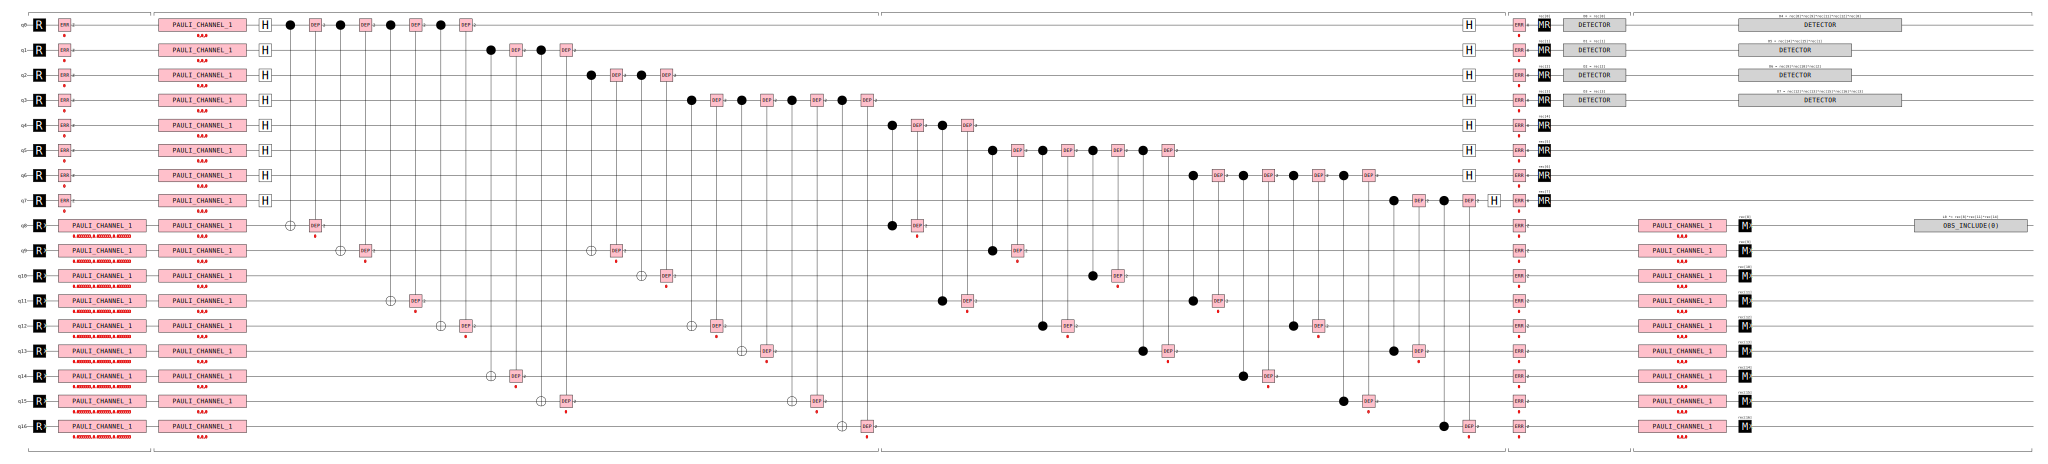

In [3]:
# check the exact logical errors from my DEM 
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
from compass_code_correlated_error import CorrelatedDecoder
from pymatching import Matching
from stim import *
import numpy as np
circuit_obj_x = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='X')
circuit_obj_z = CDCompassCodeCircuit(d=3, l=2, eta=0.5, type='Z')
circuit_1 = circuit_obj_x.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1,
                                            between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC", memory=False)
circuit_2 = circuit_obj_z.make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=0.1,
                                            between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC", memory=False)


decoder = CorrelatedDecoder(eta=0.5, d=3, l=2, corr_type="CORR_XZ")


sampler_x = circuit_1.compile_detector_sampler(seed=1) #32 is a logical error
sampler_z = circuit_2.compile_detector_sampler(seed=1)
syndrome_x, observable_flips_x = sampler_x.sample(1, separate_observables=True)
syndrome_z, observable_flips_z = sampler_z.sample(1, separate_observables=True)


print(circuit_1)
print('observable_flips_x', observable_flips_x)
print('observable_flips_z', observable_flips_z)
print('syndrome_x', syndrome_x)
print('syndrome_z', syndrome_z)
circuit_1.diagram('timeline-svg')

In [4]:
# try getting a threshold with the circuit with only the final round, no anc measurements before reconstructing stabilizer
dem_1 = circuit_1.detector_error_model(decompose_errors=True)
dem_2 = circuit_2.detector_error_model(decompose_errors=True)
syndrome_x, syndrome_z = [[True, False, False, True, False, False, False, False]], [[False, True, False, False, False, False, False, False]]

matchgraph_1 = Matching.from_detector_error_model(dem_1, enable_correlations=False)
matchgraph_2 = Matching.from_detector_error_model(dem_2, enable_correlations=False)

predictions_1 = matchgraph_1.decode_batch(syndrome_x)
predictions_2 = matchgraph_2.decode_batch(syndrome_z)

print('predictions_1', predictions_1)
print('predictions_2', predictions_2)

predictions_1 [[0]]
predictions_2 [[1]]


stim.DetectorErrorModel('''
    error(0.0666667) D0 D3
    error(0.0666667) D0 D4
    error(0.124444) D0 L0
    error(0.0666667) D1 D4
    error(0.0666667) D1 D5
    error(0.124444) D1 L0
    error(0.0666667) D2 D5
    error(0.0666667) D2 L0
    error(0.0666667) D3 D6
    error(0.0666667) D4 D6
    error(0.0666667) D4 D7
    error(0.0666667) D5 D7
    error(0.0666667) D5 D8
    error(0.0666667) D6 D9
    error(0.0666667) D6 D10
    error(0.0666667) D7 D10
    error(0.0666667) D7 D11
    error(0.0666667) D8 D11
    error(0.0666667) D9
    error(0.124444) D10
    error(0.124444) D11
    error(0.0345253) D12 D15
    error(0.0345253) D12 D15 ^ D25
    error(0.0345253) D12 D16
    error(0.0345253) D12 D16 ^ D25 D27
    error(0.0666667) D12 L0
    error(0.0345253) D13 D16
    error(0.0345253) D13 D16 ^ D27 D31
    error(0.0345253) D13 D17
    error(0.0345253) D13 D17 ^ D31 D33
    error(0.0666667) D13 L0
    error(0.0345253) D14 D17
    error(0.0345253) D14 D17 ^ D33
    error(0.0345253) D14

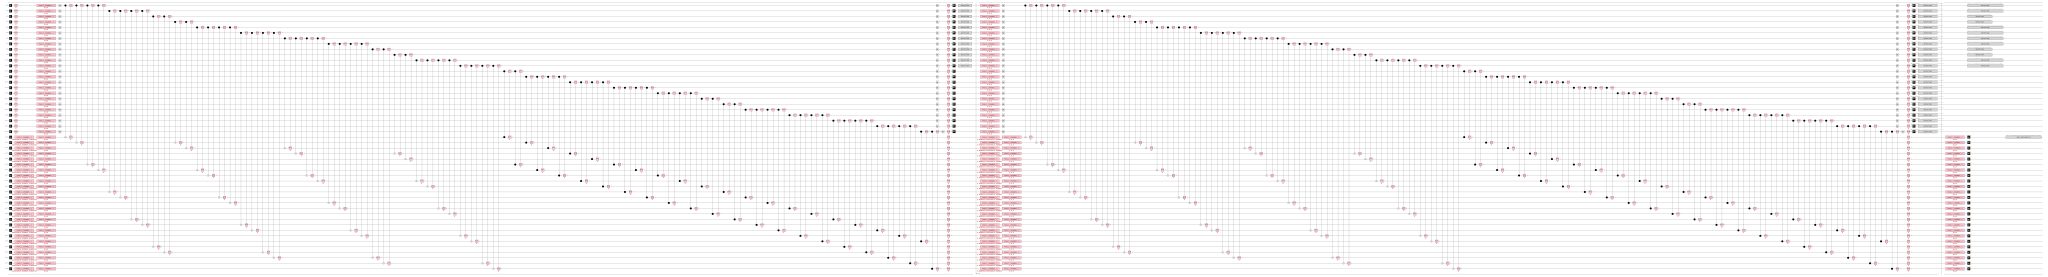

In [1]:
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
from compass_code_correlated_error import CorrelatedDecoder
from pymatching import Matching
from stim import *
import numpy as np

# test whether the DEM looks the same for the different corr decoding types
def get_circuit(d, p):
    return CDCompassCodeCircuit(d=d, l=2, eta=0.5, type='X').make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=p, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC", memory=True, phenom_meas=False)

def get_decoder(eta, d, l, corr_type):
    return CorrelatedDecoder(eta=eta, d=d, l=l, corr_type=corr_type)

circuit = get_circuit(5, 0.1)
decoder = get_decoder(0.5, 5, 2, "CORR_XZ")

# all three decode on the same DEM ... wanna know whether the edges that we use to get joint probabilities are the same in my decoder as pymatching - otherwise might be ascribing corrections to the wrong edges
# chat says that I need to be using a star decompostion, where i am using pairwise. Can't find it in pymatching
# how to test it... 
dem = circuit.detector_error_model(decompose_errors=True)
print(repr(dem))
matching_1 = Matching.from_detector_error_model(dem, enable_correlations=True) # pymatching correlated decoder
matching_2 = Matching.from_detector_error_model(dem, enable_correlations=False) # pymatching uncorrelated decoder
# as far as i can tell, the matchgraphs for the dem with enable_correlations=True and False are the same ... so pymatching is not using the joint probabilities at all? why even have the option then


print(matching_1.edges())
print(matching_2.edges())
joint_probs, fault_ids = decoder.get_joint_prob(dem)
print('joint probabilities from my correlated decoder', joint_probs)

# first check whether my correlated decoder has anything in joint probabilities with decompose_errors = True
# next, check whether the edge decomposition star vs pairwise makes a difference in pymatching
# circuit.diagram('timeline-svg')
# try the one error approach
circuit.diagram('timeline-svg')


In [9]:
def decompose_dem_instruction_stim(self, inst):
    """
    Decomposes a stim DEM instruction into pairwise detector edges and assigns observables
    to the edges based on which sub-block (separated by `^`) the observable appeared in.

    Example:
        error(p) D0 D1^D2 L0 -> detectors = [(0, -1), (2, -1)], observables = [None, 0]
        error(p) D0 D1 L0^D2 -> detectors = [(0, 1), (-1, 2)], observables = [0, None]

    Returns:
        {
            'p': float,
            'detectors': List[Tuple[int, int]],
            'observables': List[Optional[int]],
        }
    """
    targets = list(inst.targets_copy())
    p = inst.args_copy()[0]

    blocks = []  # Each block is a list of targets between separators (^)
    current_block = []

    for t in targets:
        if t.is_separator():
            if current_block:
                blocks.append(current_block)
                current_block = []
        else:
            current_block.append(t)

    if current_block:
        blocks.append(current_block)

    detector_edges = []
    edge_observables = []

    for block in blocks:
        dets = []
        obs = []

        for t in block:
            if t.is_relative_detector_id():
                dets.append(t.val)
            elif t.is_logical_observable_id():
                obs.append(t.val)

        # Handle detectors → edges
        if len(dets) == 0:
            continue  # no detector => no edge
        elif len(dets) == 1:
            edge = (-1, dets[0])  # boundary edge
            detector_edges.append(edge)
            edge_observables.append(obs[0] if obs else None)
        else:
            # Decompose pairwise through chain
            for i in range(len(dets) - 1):
                edge = tuple(sorted((dets[i], dets[i+1])))
                detector_edges.append(edge)
                edge_observables.append(obs[0] if obs else None)

    return {
        "p": p,
        "detectors": detector_edges,
        "observables": edge_observables
    }


for inst in dem:
    if inst.type == "error":
        decomposed = decompose_dem_instruction_stim(dem, inst)
        print(inst, decomposed)

error(0.0666667) D0 D3 {'p': 0.06666666666666667, 'detectors': [(0, 3)], 'observables': [None]}
error(0.0666667) D0 D4 {'p': 0.06666666666666667, 'detectors': [(0, 4)], 'observables': [None]}
error(0.124444) D0 L0 {'p': 0.12444444444444444, 'detectors': [(-1, 0)], 'observables': [0]}
error(0.0666667) D1 D4 {'p': 0.06666666666666667, 'detectors': [(1, 4)], 'observables': [None]}
error(0.0666667) D1 D5 {'p': 0.06666666666666667, 'detectors': [(1, 5)], 'observables': [None]}
error(0.124444) D1 L0 {'p': 0.12444444444444444, 'detectors': [(-1, 1)], 'observables': [0]}
error(0.0666667) D2 D5 {'p': 0.06666666666666667, 'detectors': [(2, 5)], 'observables': [None]}
error(0.0666667) D2 L0 {'p': 0.06666666666666667, 'detectors': [(-1, 2)], 'observables': [0]}
error(0.0666667) D3 D6 {'p': 0.06666666666666667, 'detectors': [(3, 6)], 'observables': [None]}
error(0.0666667) D4 D6 {'p': 0.06666666666666667, 'detectors': [(4, 6)], 'observables': [None]}
error(0.0666667) D4 D7 {'p': 0.06666666666666667

In [3]:
# I think the edges are the same ... 
# check graph is changing with joint correction updates
# try checking a single correlated error / an error that should flip X and Z
circuit = get_circuit(5, 0.1)
decoder = get_decoder(0.5, 5, 2, "CORR_XZ")

dem = circuit.detector_error_model(decompose_errors=True)
matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
matchgraph_pycorr = Matching.from_detector_error_model(dem, enable_correlations=True)
print("matching edges",matchgraph.edges())
joint_probs, fault_ids = decoder.get_joint_prob(dem)
print("joint_probs",joint_probs)
cond_prob_dict = decoder.get_conditional_prob(joint_probs)
syndrome = np.zeros((1, dem.num_detectors), dtype=bool)
syndrome[0][20] = True
syndrome[0][23] = True
syndrome[0][34] = True
syndrome[0][38] = True
syndrome[0][73] = True
syndrome[0][75] = True
syndrome[0][84] = True
syndrome[0][87] = True
syndrome[0][88] = True
syndrome[0][89] = True
syndrome[0][90] = True
syndrome[0][106] = True
syndrome[0][107] = True
print("syndrome",syndrome)
edges_in_correction = matchgraph.decode_to_edges_array(syndrome[0])
print("correction first pass edges", edges_in_correction)
updated_weights, fault_ids_dict = decoder.compute_edge_weights_from_conditional_probs(edges_in_correction, matchgraph, cond_prob_dict)
print("updated weights",updated_weights)
matching_corr = decoder.build_matching_from_weights(updated_weights, fault_ids_dict, matchgraph.num_nodes)
print("matching correlated",matching_corr.edges())

for edge1, edge2,edge3 in zip(matchgraph.edges(), matching_corr.edges(), matchgraph_pycorr.edges()):
   if edge1[2]['weight'] != edge2[2]['weight']:
      print("edge uncorrelated:", edge1, "edge correlated:", edge2, "edge pymatching correlated:", edge3)

# get the correction from my correlated decoder
correction_edges_corr = matching_corr.decode_to_edges_array(syndrome[0])
print("2nd correction edges correlated", correction_edges_corr)

# get the correction from pymatching correlated decoder
correction_edges_pycorr = matchgraph_pycorr.decode_to_edges_array(syndrome[0], enable_correlations=True)
print("correction edges pymatching correlated", correction_edges_pycorr)


# Trigger internal correlation-aware update
_ = matchgraph_pycorr.decode(syndrome, enable_correlations=True)

# Now print the edges — these include updated fault_ids and weights
for u, v, data in matchgraph_pycorr.edges():
    print(f"{u} — {v} : weight = {data['weight']:.4f}, fault_ids = {data['fault_ids']}")



matching edges [(0, 3, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (1, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (2, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (2, None, {'fault_ids': {0}, 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (3, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (4, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'erro

In [7]:
joint_probs, fault_ids = decoder.get_joint_prob(dem)
print(f"fault ids from dem: {fault_ids}")
cond_prob_dict = decoder.get_conditional_prob(joint_probs)
matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
edges_in_correction = matchgraph.decode_to_edges_array(syndrome[0])
updated_weights, fault_ids_matchgraph = decoder.compute_edge_weights_from_conditional_probs(edges_in_correction, matchgraph, cond_prob_dict)
print(f"fault ids from matchgraph: {fault_ids_matchgraph}")

for edge1, edge2 in zip(fault_ids, fault_ids_matchgraph):
    print(f"{edge1} from dem: {fault_ids[edge1]}, {edge2} from matchgraph: {fault_ids_matchgraph[edge2]}")


fault ids from dem: {(0, 3): None, (0, 4): None, (-1, 0): 0, (1, 4): None, (1, 5): None, (-1, 1): 0, (2, 5): None, (-1, 2): 0, (3, 6): None, (4, 6): None, (4, 7): None, (5, 7): None, (5, 8): None, (6, 9): None, (6, 10): None, (7, 10): None, (7, 11): None, (8, 11): None, (-1, 9): None, (-1, 10): None, (-1, 11): None, (12, 15): None, (-1, 25): None, (12, 16): None, (25, 27): None, (-1, 12): 0, (13, 16): None, (27, 31): None, (13, 17): None, (31, 33): None, (-1, 13): 0, (14, 17): None, (-1, 33): None, (-1, 14): 0, (15, 18): None, (16, 18): None, (25, 28): None, (16, 19): None, (28, 31): None, (17, 19): None, (31, 34): None, (17, 20): None, (-1, 34): None, (18, 21): None, (-1, 26): None, (18, 22): None, (26, 28): None, (19, 22): None, (28, 32): None, (19, 23): None, (32, 34): None, (20, 23): None, (-1, 21): None, (-1, 22): None, (-1, 23): None, (-1, 24): None, (24, 27): None, (26, 29): None, (27, 30): None, (29, 32): None, (30, 33): None, (32, 35): None, (-1, 35): None, (36, 39): None, (-1

In [ ]:
# generate an error in the circuit that is detected by the pymatching corr but not regular corr, test it on mycorr

circuit = get_circuit(5, 0.1)
decoder = get_decoder(0.5, 5, 2, "CORR_XZ") # my decoder
num_shots = 1000


dem = circuit.detector_error_model(decompose_errors=True)
matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
matchgraph_py_corr = Matching.from_detector_error_model(dem, enable_correlations=True)
print("matching edges",matchgraph.edges())
joint_probs = decoder.get_joint_prob(dem)
print("joint_probs",joint_probs)
cond_prob_dict = decoder.get_conditional_prob(joint_probs)

seed = 1
syndrome, observable_flips = circuit.compile_detector_sampler(seed=seed).sample(num_shots, separate_observables=True)

for i in range(num_shots):
    syndrome_i = syndrome[i].reshape(1, -1)
    edges_in_correction = matchgraph.decode_to_edges_array(syndrome_i)
    updated_weights, fault_ids_dict = decoder.compute_edge_weights_from_conditional_probs(edges_in_correction, matchgraph, cond_prob_dict)
    matching_corr = decoder.build_matching_from_weights(updated_weights, fault_ids_dict, matchgraph.num_nodes)
    edges_in_my_correction = matching_corr.decode_to_edges_array(syndrome_i)
    edges_in_pycorr_correction = matchgraph_py_corr.decode_to_edges_array(syndrome_i, enable_correlations=True)
    predictions_corr = matching_corr.decode(syndrome_i) 
    predictions_uncorr = matchgraph.decode(syndrome_i)
    predictions_py_corr = matchgraph_py_corr.decode(syndrome_i, enable_correlations=True)
    
    error_no_corr = observable_flips[i] != predictions_uncorr[0]
    error_py_corr = observable_flips[i] != predictions_py_corr[0]
    error_my_corr = observable_flips[i] != predictions_corr[0]


    if (error_no_corr and error_my_corr) and not error_py_corr:
        print(f"Shot {i}")
        print("Found an error that pymatching correlated decoder corrects but uncorrelated does not")
        # print("syndrome",syndrome_i)
        # print(f"edges in uncorrelated correction and correlated correction are {edges_in_correction == edges_in_my_correction}")
        print("edges in correction", edges_in_correction)
        print("edges in my correlated correction", edges_in_my_correction)
        print("updated weights and fault_ids",updated_weights, fault_ids_dict)
        print("matching correlated",matching_corr.edges())
        print("error_py_corr", error_py_corr)
        print("error_my_corr", error_my_corr)

       

matching edges [(0, 3, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (1, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (2, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (2, None, {'fault_ids': {0}, 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (3, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (4, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'erro

In [ ]:
# now test directly against functions in my correlated decoder class

circuit = get_circuit(5, 0.1)
decoder = get_decoder(0.5, 5, 2, "CORR_XZ") # my decoder
num_shots = 1000


dem = circuit.detector_error_model(decompose_errors=True)
matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
matchgraph_py_corr = Matching.from_detector_error_model(dem, enable_correlations=True)
print("matching edges",matchgraph.edges())
joint_probs = decoder.get_joint_prob(dem)
print("joint_probs",joint_probs)
cond_prob_dict = decoder.get_conditional_prob(joint_probs)

# seed = 1
syndrome, observable_flips = circuit.compile_detector_sampler(seed=seed).sample(num_shots, separate_observables=True)

for i in range(num_shots):
    syndrome_i = syndrome[i].reshape(1, -1)
    # print("syndrome_i", syndrome_i)
    edges_in_correction = matchgraph.decode_to_edges_array(syndrome_i[0])
    updated_weights, fault_ids_dict = decoder.compute_edge_weights_from_conditional_probs(edges_in_correction, matchgraph, cond_prob_dict)
    matching_corr = decoder.build_matching_from_weights(updated_weights, fault_ids_dict, matchgraph.num_nodes)
    # predictions_corr = matching_corr.decode(syndrome_i) 
    predictions_uncorr = matchgraph.decode(syndrome_i)
    predictions_py_corr = matchgraph_py_corr.decode(syndrome_i, enable_correlations=True)
    
    error_no_corr = observable_flips[i] != predictions_uncorr[0]
    error_py_corr = observable_flips[i] != predictions_py_corr[0]

    if (error_no_corr) and not error_py_corr:
        print(f"Shot {i}")
        print("Found an error that pymatching correlated decoder corrects but uncorrelated does not")
        print("syndrome",syndrome_i)
        print("edges in correction first pass", edges_in_correction)
        error_my_corr = decoder.decoding_failures_correlated_circuit_level(circuit, 1) # run for a single shot
        # print("edges in correction", edges_in_correction)
        # print("updated weights and fault_ids",updated_weights, fault_ids_dict)
        # print("matching correlated",matching_corr.edges())
        print("error_py_corr", error_py_corr)
        print("error_my_corr", error_my_corr)
        if error_my_corr != error_py_corr:
            print("Discrepancy between pymatching correlated decoder and my correlated decoder")
            edges_pycorr = matchgraph_py_corr.decode_to_edges_array(syndrome_i[0], enable_correlations=True)
            # print("edges in pymatching correlated correction", edges_pycorr)
            edges_my_corr = matching_corr.decode_to_edges_array(syndrome_i[0])
            # print("edges in my correlated correction", edges_my_corr)
            print(f"are my correction edges same as pymatching correlated correction edges? {np.array_equal(edges_pycorr, edges_my_corr)}")


"""
Found an error that pymatching correlated decoder corrects but uncorrelated does not
syndrome [[False False False False False False False False False False False False 11
  False False False False False False False False  True False False  True 23
  False False False False False False False False False False  True False 35
  False False  True False False False False False False False False False 47
  False False False False False False False False False False False False 59
  False False False False False False False False False False False False 71
  False  True False  True False False False False False False False False 83
   True False False  True  True  True  True False False False False False 95
  False False False False False False False False False False  True  True 107
  False False False False False False False False False False False False]] 119
edges in correction outside function [[ 20  23]
 [ 34  -1]
 [ 38  -1]
 [ 73  75]
 [ 84  88]
 [ 87  90]
 [ 85  89]
 [ 85  -1]
 [106  -1]
 [107  -1]]
error_py_corr [False]
error_my_corr [ True]
"""

matching edges [(0, 3, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (0, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (1, 4, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (1, None, {'fault_ids': {0}, 'weight': 1.9509992185627845, 'error_probability': 0.12444444444444444}), (2, 5, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (2, None, {'fault_ids': {0}, 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (3, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'error_probability': 0.06666666666666667}), (4, 6, {'fault_ids': set(), 'weight': 2.6390573296152584, 'erro

'\nFound an error that pymatching correlated decoder corrects but uncorrelated does not\nsyndrome [[False False False False False False False False False False False False 11\n  False False False False False False False False  True False False  True 23\n  False False False False False False False False False False  True False 35\n  False False  True False False False False False False False False False 47\n  False False False False False False False False False False False False 59\n  False False False False False False False False False False False False 71\n  False  True False  True False False False False False False False False 83\n   True False False  True  True  True  True False False False False False 95\n  False False False False False False False False False False  True  True 107\n  False False False False False False False False False False False False]] 119\nedges in correction outside function [[ 20  23]\n [ 34  -1]\n [ 38  -1]\n [ 73  75]\n [ 84  88]\n [ 87  90]\n [ 85  89

In [ ]:
import stim
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
from compass_code_correlated_error import CorrelatedDecoder
dem_1 = stim.DetectorErrorModel('''
error(0.0666667) D0 D1 ^ D2 D3 L0
                                ''')

decoder = CorrelatedDecoder(0.5, 3, 2, "CORR_XZ")

for inst in dem_1:
    print(inst)
    decomp_edges_stim_auto = decoder.decompose_dem_instruction_stim(inst)
    decomp_edges_star = decoder.decompose_dem_instruction_star(inst)
    print('decomp_edges_stim_auto', decomp_edges_stim_auto)
    print('decomp_edges_star', decomp_edges_star)

error(0.0666667) D0 D1 ^ D2 D3 L0
decomp_edges_stim_auto {'p': 0.0666667, 'detectors': [(0, 1), (2, 3)], 'observables': [0]}
decomp_edges_star {'p': 0.0666667, 'detectors': [(0, 1), (0, 2), (0, 3)], 'observables': [0]}


In [ ]:

shots = 1000

d_list = [3,5,7]
p_list = np.linspace(0.07, 0.13, 6)

ler_no_corr = np.zeros((len(d_list), len(p_list)))
ler_py_corr = np.zeros((len(d_list), len(p_list)))
ler_my_corr = np.zeros((len(d_list), len(p_list)))

for d in d_list:
    for p in p_list:
        print(f"Running d={d}, p={p}")
        circuit = get_circuit(d, p)
        decoder = get_decoder(0.5, d, 2, "CORR_XZ") # my decoder

        # now try running code without function wrapper
        dem = circuit.detector_error_model(decompose_errors=True) 
        matchgraph = Matching.from_detector_error_model(dem, enable_correlations=False)
        matchgraph_py_corr = Matching.from_detector_error_model(dem, enable_correlations=True)

        # get the joint probabilities table of the dem hyperedges
        joint_prob_dict = decoder.get_joint_prob(dem)

        # calculate the conditional probabilities based on joint probablities and marginal probabilities 
        cond_prob_dict = decoder.get_conditional_prob(joint_prob_dict)
                
                
        #
        # Decode the circuit
        #

        # first round of decoding
        # get the syndromes and observable flips
        seed = np.random.randint(0, 2**32 - 1)
        sampler = circuit.compile_detector_sampler(seed=seed)
        syndrome, observable_flips = sampler.sample(shots, separate_observables=True)

        error_no_corr = 0
        error_py_corr = 0
        error_my_corr = 0

        disagree_count = 0
        for i in range(shots):
            edges_in_correction = matchgraph.decode_to_edges_array(syndrome[i])

            # second round of decoding with updated weights
            updated_weights, fault_ids_dict = decoder.compute_edge_weights_from_conditional_probs(edges_in_correction, matchgraph, cond_prob_dict)
            matching_corr = decoder.build_matching_from_weights(updated_weights, fault_ids_dict, matchgraph.num_nodes)
            corrections_my_corr = matching_corr.decode(syndrome[i])
            corrections_uncorr = matchgraph.decode(syndrome[i])
            corrections_py_corr = matchgraph_py_corr.decode(syndrome[i], enable_correlations=True)

            error_no_corr += observable_flips[i] != corrections_uncorr
            error_py_corr += observable_flips[i] != corrections_py_corr
            error_my_corr += observable_flips[i] != corrections_my_corr
            
            if (observable_flips[i] != corrections_uncorr and observable_flips[i] != corrections_my_corr) and not observable_flips[i] != corrections_py_corr:
                # print("Pymatching corr and my corr disagree")
                # print("syndrome:", syndrome[i])
                # print("my corr corrections:", corrections_my_corr)
                # print("py corr corrections:", corrections_py_corr)
                disagree_count += 1
        print("disagree count:", disagree_count)
        ler_no_corr[d_list.index(d), p_list.tolist().index(p)] = error_no_corr/shots
        ler_py_corr[d_list.index(d), p_list.tolist().index(p)] = error_py_corr/shots
        ler_my_corr[d_list.index(d), p_list.tolist().index(p)] = error_my_corr/shots





Running d=3, p=0.07
disagree count: 0
Running d=3, p=0.082


/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_99296/4221640765.py:64: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ler_no_corr[d_list.index(d), p_list.tolist().index(p)] = error_no_corr/shots
/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_99296/4221640765.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ler_py_corr[d_list.index(d), p_list.tolist().index(p)] = error_py_corr/shots
/var/folders/m6/1pcn_m250l175cmxwtstjnxh0000gn/T/ipykernel_99296/4221640765.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from 

disagree count: 0
Running d=3, p=0.094
disagree count: 0
Running d=3, p=0.10600000000000001
disagree count: 0
Running d=3, p=0.11800000000000001
disagree count: 0
Running d=3, p=0.13
disagree count: 0
Running d=5, p=0.07
disagree count: 0
Running d=5, p=0.082
disagree count: 0
Running d=5, p=0.094
disagree count: 0
Running d=5, p=0.10600000000000001
disagree count: 3
Running d=5, p=0.11800000000000001
disagree count: 0
Running d=5, p=0.13
disagree count: 0
Running d=7, p=0.07
disagree count: 34
Running d=7, p=0.082
disagree count: 47
Running d=7, p=0.094
disagree count: 60
Running d=7, p=0.10600000000000001
disagree count: 83
Running d=7, p=0.11800000000000001
disagree count: 95
Running d=7, p=0.13
disagree count: 112


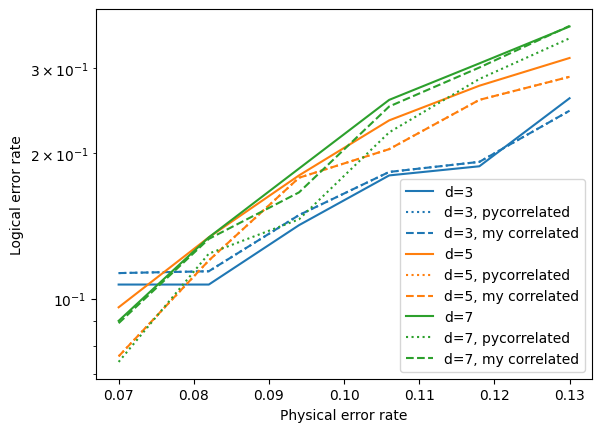

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

for i in range(len(d_list)):
    d = d_list[i]
    lers = [x for x in ler_no_corr[i]]
    lers_corr = [x for x in ler_py_corr[i]]
    lers_my_corr = [x for x in ler_my_corr[i]]
    line, = plt.plot(p_list, lers, label=f"d={d}")
    line_color = line.get_color()
    plt.plot(p_list, lers_corr, ":", label=f"d={d}, pycorrelated", color=line_color)
    plt.plot(p_list, lers_my_corr, "--", label=f"d={d}, my correlated", color=line_color)

plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);
plt.show()

In [ ]:
# do exactly pymatching code
# check the exact logical errors from my DEM 
from clifford_deformed_cc_circuit import CDCompassCodeCircuit
from compass_code_correlated_error import CorrelatedDecoder
from pymatching import Matching
from stim import *
import numpy as np

def get_circuit(d, p):
    return CDCompassCodeCircuit(d=d, l=2, eta=0.5, type='X').make_elongated_circuit_from_parity(before_measure_flip=0, before_measure_pauli_channel=0, after_clifford_depolarization=0, before_round_data_pauli_channel=p, between_round_idling_pauli_channel=0, idling_dephasing=0, CD_type="SC", memory=True, phenom_meas=False)

def get_logical_error_rate(circuit, num_shots, decoder):
    sampler= circuit.compile_detector_sampler()
    dets, obs = sampler.sample(num_shots, separate_observables=True)
    matching = Matching.from_detector_error_model(circuit.detector_error_model(decompose_errors=True), enable_correlations=False)
    matching_corr = Matching.from_detector_error_model(circuit.detector_error_model(decompose_errors=True), enable_correlations=True)
    predictions = matching.decode_batch(dets)
    predictions_corr = matching_corr.decode_batch(dets, enable_correlations=True)
    
    num_logical_errors = np.sum(np.any(np.array(obs) != np.array(predictions), axis=1))
    num_logical_errors_corr = np.sum(np.any(np.array(obs) != np.array(predictions_corr), axis=1))
    num_logical_errors_my_corr = np.sum(decoder.decoding_failures_correlated_circuit_level(circuit, num_shots)) # not same seed, predictions or sampler so might be different
    
    return num_logical_errors / num_shots, num_logical_errors_corr/num_shots, num_logical_errors_my_corr / num_shots

distances = list(range(5,14,4))
ps = np.linspace(0.07, 0.13, 6)
num_shots = 1000

# its the memory experiment that takes forever, why ? how much bigger is the parity check mat

ler_all_distances = []
ler_all_distances_corr = []
ler_all_distances_my_corr = []

for d in distances:
    ler_for_ps = []
    ler_for_ps_corr = []
    ler_for_ps_my_corr = []
    for p in ps:
        circuit = get_circuit(d=d, p=p)
        decoder = CorrelatedDecoder(eta=0.5, d=d, l=2, corr_type="CORR_XZ")
        ler, ler_corr, ler_my_corr = get_logical_error_rate(
            circuit=circuit, num_shots=num_shots, decoder=decoder
        )
        ler_for_ps.append(ler)
        ler_for_ps_corr.append(ler_corr)
        ler_for_ps_my_corr.append(ler_my_corr)
    ler_all_distances.append(ler_for_ps)
    ler_all_distances_corr.append(ler_for_ps_corr)
    ler_all_distances_my_corr.append(ler_for_ps_my_corr)


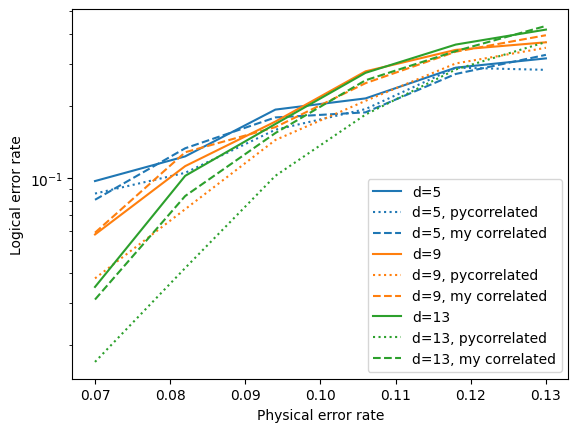

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()

for i in range(len(d_list)):
    d = distances[i]
    lers = [x for x in ler_all_distances[i]]
    lers_corr = [x for x in ler_all_distances_corr[i]]
    lers_my_corr = [x for x in ler_all_distances_my_corr[i]]

    line, = plt.plot(ps, lers, label=f"d={d}")
    line_color = line.get_color()
    plt.plot(ps, lers_corr, ":", label=f"d={d}, pycorrelated", color=line_color)
    plt.plot(ps, lers_my_corr, "--", label=f"d={d}, my correlated", color=line_color)


plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.legend(loc=0);
plt.show()

In [ ]:
import pandas as pd

output_file = "/Users/ariannameinking/Documents/Brown_Research/correlated_error_biased_noise/circuit_data.csv"
df = pd.read_csv(output_file)
l = 6
eta = 0.5
num_shots = 26315
noise_model = "code_cap"
CD_type = "XZZXonSqu"
d = 17 


filtered_df = df[(df['l'] == l) & (df['eta'] == eta) & (df['num_shots'] == num_shots) & (df['noise_model'] == noise_model) & (df['CD_type'] == CD_type) & (df['d'] == d) & (df['error_type'] == 'TOTAL_MEM') & (df['p'] == 0.05)]

# data_mean = data.groupby('p', as_index=False)['num_log_errors'].mean()
print(filtered_df)

            d  num_shots     p    l  eta error_type  num_log_errors  \
8516140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8534740  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8541340  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8546140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8564140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8586940  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8604940  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8636140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8655940  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8660140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8693140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8708140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
8723140  17.0    26315.0  0.05  6.0  0.5  TOTAL_MEM         0.00836   
874714